# Utilizing GluonTS for Detecting Potential Anomalies
### Resource:
https://gluon-ts.mxnet.io/examples/basic_forecasting_tutorial/tutorial.html
### Author:
YoungSeok (Alex) Na

### Sample Image:

In [1]:
from IPython.display import Image

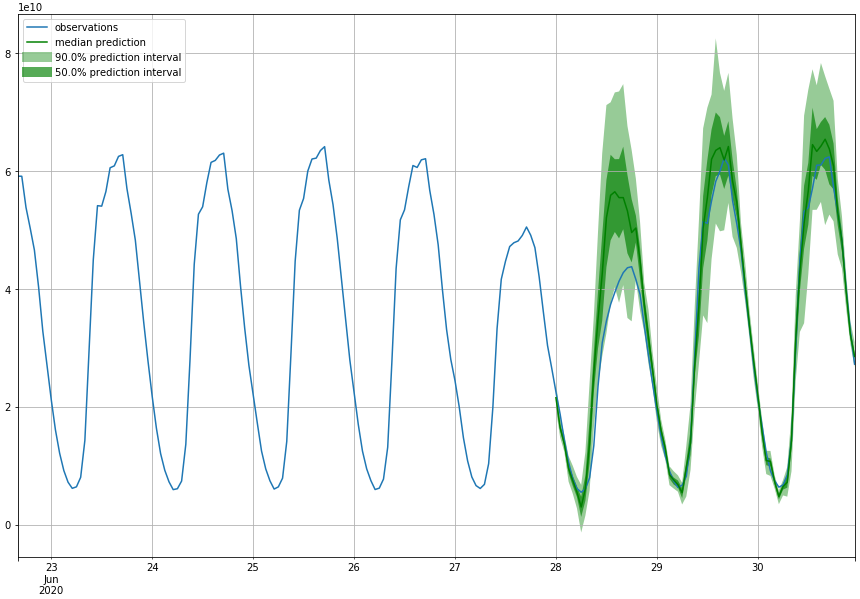

In [2]:
Image(filename='./img/wo_ad.png')

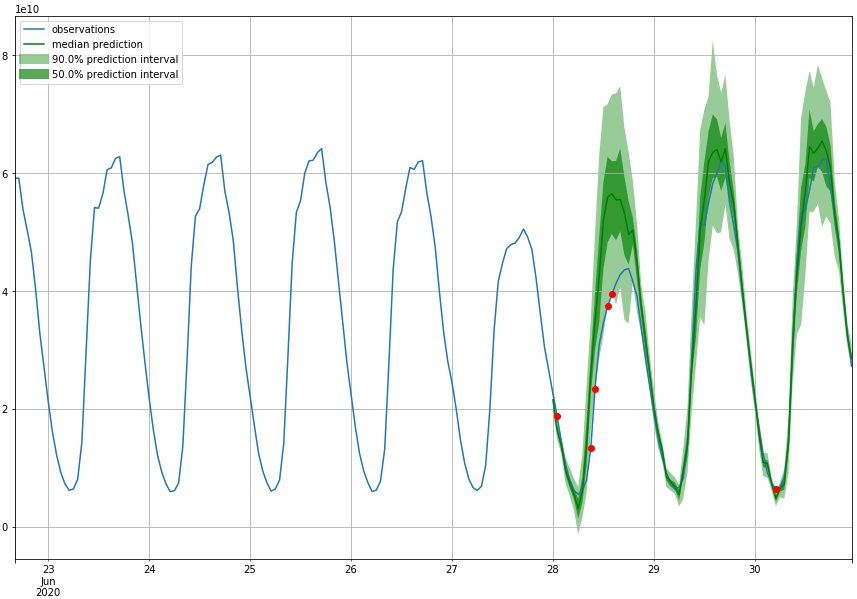

In [3]:
Image(filename='./img/w_ad.png')

## Introduction
GluonTS enables us to easily forecast future data easily through well-structured abstraction of time-series forecasting method. To incorporate the functionality of anomaly-detection, I decided to utilize the source code provided for plotting the predictions.

### 1. Import necessary modules

In [ ]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from plotly.offline import iplot
import plotly.graph_objs as go

### 2. Data Preparation
Clean up the time-series data

In [ ]:
df = pd.read_csv('__.csv')
df['Time'] = df['Time'].str.split('+').str[0]
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values(by=['Time'])
df.index = df['Time']
df = df.drop(columns='Time')
df = df.resample('H').sum() # Refactor data into hourly step-size
df.tail()

### 3. Convert the dataset to a GluonTS-friendly format
We make use of _ListDataset_ module provided by GluonTS to reform the data

In [ ]:
from gluonts.dataset.common import ListDataset 
freq = 'H'
start = df.index[0]
prediction_length = 72 # Can be changed freely
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': df['Value'][:-prediction_length], 'start': start}],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': df['Value'], 'start': start}],
                      freq=freq)

### 4. Create a model
Utilizing the pre-built feed-forward model, we formulate the model that is going to be used to predict the future data.

In [ ]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer # defines how the model will be trained

# Define hyperparameters
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions = [10],
    prediction_length = prediction_length,
    context_length = 100, # Dependent on prediction_length?
    freq = freq,
    trainer = Trainer(ctx = "cpu",
                      epochs = 10,
                      learning_rate = 1e-3,
                      num_batches_per_epoch = 100
                     )
)
predictor = estimator.train(train_ds)

### 5. Extract out prediction and test data

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds, # test dataset
    predictor = predictor, # predictor
    num_samples = 100, # number of sample paths we want for evaluation
    # Dependent on prediction_length?
)

forecasts = list(forecast_it)
tss = list(ts_it)

forecast_entry = forecasts[0]
ts_entry = tss[0]

### 6. Plot the prediction

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200 # if prediction_length is changed, we must also change this value
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
plot_prob_forecasts(ts_entry, forecast_entry)

### 7. Model Evaluation

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

### 8. Integrate Anomaly Detection Logic 
Though the tutorial displayed in the documentation stops after plotting the graph, I went further to understand the plotting logic to physically experiment with boundary values for the prediction.

After extracting the values, I have decided to label points that were outside of the 90% CI as anomalies.

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    
    #+++++++++++++++++++++++++++++++++++++++++++++++++++
    test_df = ts_entry[-prediction_length:]
    test_df.rename(columns={0:'Vals'}, inplace=True)
    idx_t = 0
    
    for index, values in test_df.iterrows():
        anomaly = (forecast_entry.quantile(0.05)[idx_t] > values['Vals']) or (forecast_entry.quantile(0.95)[idx_t] < values['Vals'])
        if (anomaly):
            plt.plot(index, values['Vals'], 'o', color='red')
        idx_t += 1        
    #+++++++++++++++++++++++++++++++++++++++++++++++++++
    
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
plot_prob_forecasts(ts_entry, forecast_entry)